In [5]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 13.4: Measures of Predictive Accuracy

## Objectives

+ To introduce measures that quantify how good a regression model is.

## Validation dataset

You cannot test how good your model is using the training dataset.
Whatever the metric you use, the performance of your model on the training dataset will always be quite good.
This is because the model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never see.
This brings us to the concept of a *validation dataset*.
How can you make a validation dataset?
Well, take whatever data you have a split it into training and validation dataset.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your validation set.

Let's do this for the motorcyle dataset:

In [6]:
# Load the data
data = np.loadtxt('motor.dat')
# Figure out how many observations you have
num_obs = data.shape[0]
# Select what percentage you want to put in the training data
train_percentage = 0.7
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
print('num_train = {0:d}, num_valid = {1:d}'.format(num_train, num_valid))

num_train = 65, num_valid = 29


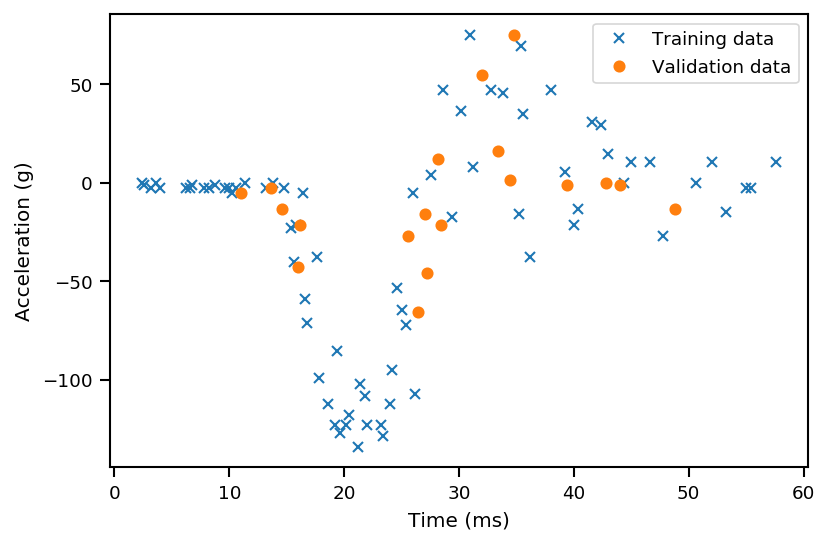

In [89]:
# Before splitting the data, randomly permute rows
permuted_data = np.random.permutation(data)
# Split
train_data = permuted_data[:num_train] # This picks the first n_train rows
valid_data = permuted_data[num_train:] # This puts the rest on the validation rows
# Get the x's and the y's for regression
x_train = train_data[:, 0]
y_train = train_data[:, 1]
x_valid = valid_data[:, 0]
y_valid = valid_data[:, 1]
# Let's plot the training and the validation datasets in different colors
fig, ax = plt.subplots(dpi=150)
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best');

In [92]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """
    Fourier expansion with ``num_terms`` cosines and sines.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(1, int(num_terms / 2)):
        cols.append(np.cos(2 * i * np.pi / L * x))
        cols.append(np.sin(2 * i * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

MSE_poly = 121.40


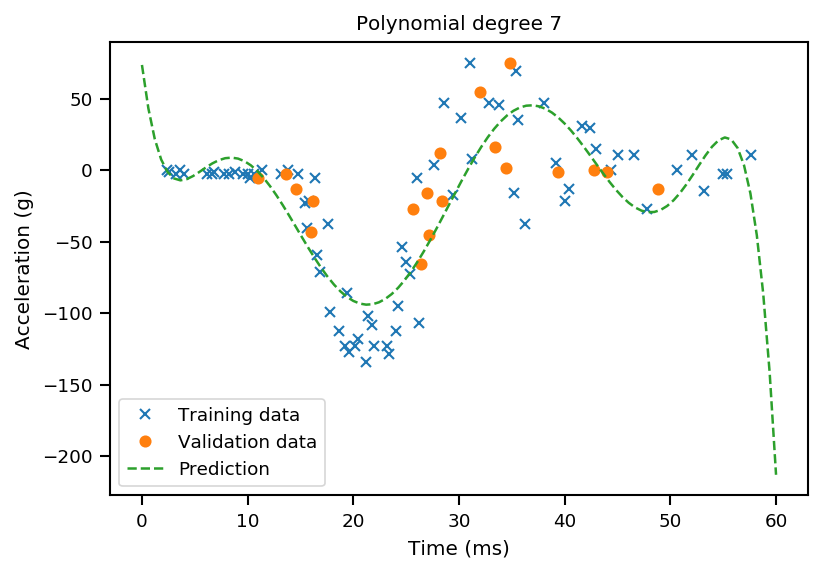

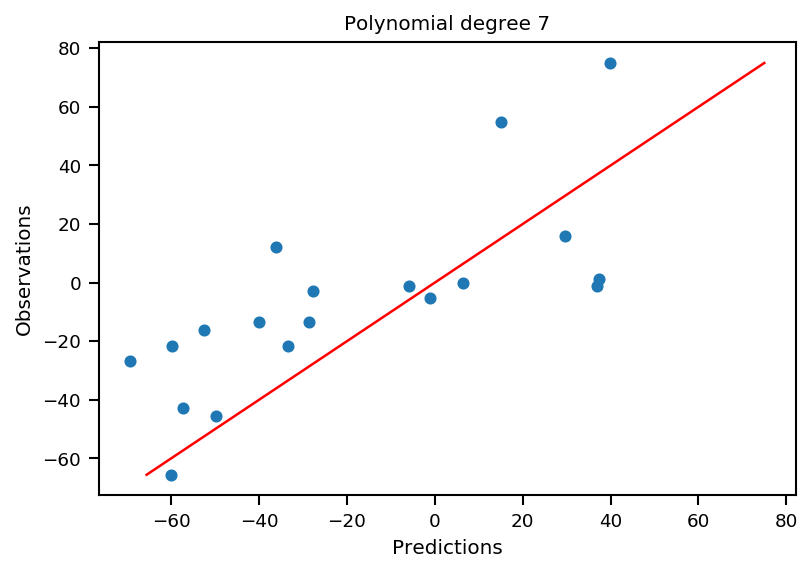

In [93]:
# Fit the polynomial model
degree = 7
Phi_poly_train = get_polynomial_design_matrix(x_train[:, None], degree)
w_poly, _, _, _ = np.linalg.lstsq(Phi_poly_train, y_train, rcond=None)
# Plot the function when possible
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = np.dot(Phi_poly_xx, w_poly)
fig, ax = plt.subplots(dpi=150)
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
# Make predictions on the validation data
Phi_poly_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_valid_predict = np.dot(Phi_poly_valid, w_poly)
# Calculate the mean square error
MSE_poly = np.linalg.norm(y_valid_predict - y_valid)
print('MSE_poly = {0:1.2f}'.format(MSE_poly))
# Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

MSE_fourier = 75.24


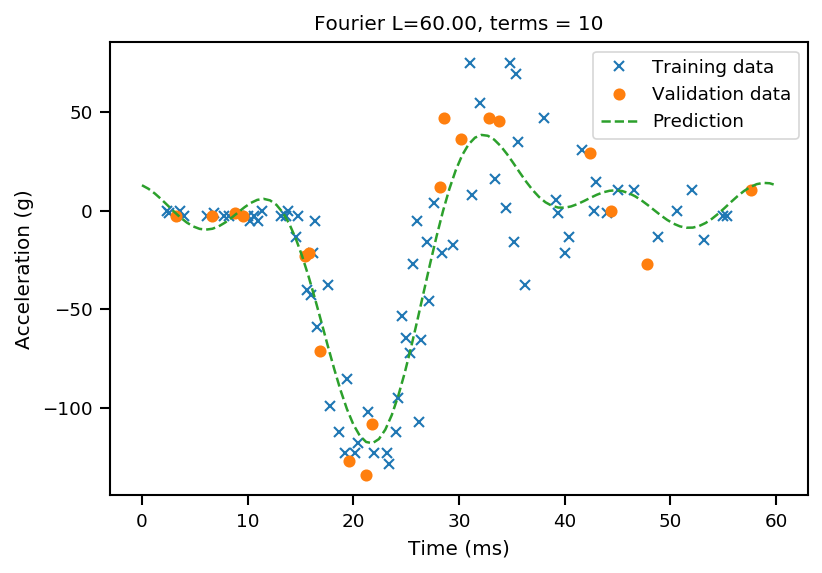

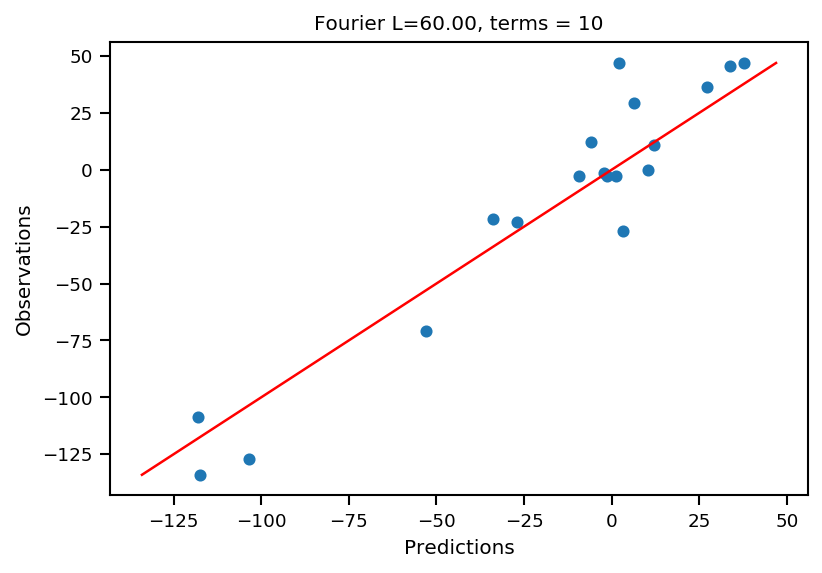

In [101]:
# Fit the Fourier model
fourier_terms = 10
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)
# Plot the function when possible
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(xx[:, None], fourier_L, fourier_terms)
yy_predict = np.dot(Phi_fourier_xx, w_fourier)
fig, ax = plt.subplots(dpi=150)
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
# Make predictions on the validation data
Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
# Calculate the mean square error
MSE_fourier = np.linalg.norm(y_valid_predict - y_valid)
print('MSE_fourier = {0:1.2f}'.format(MSE_fourier))
## Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

MSE_rbf = 104.18


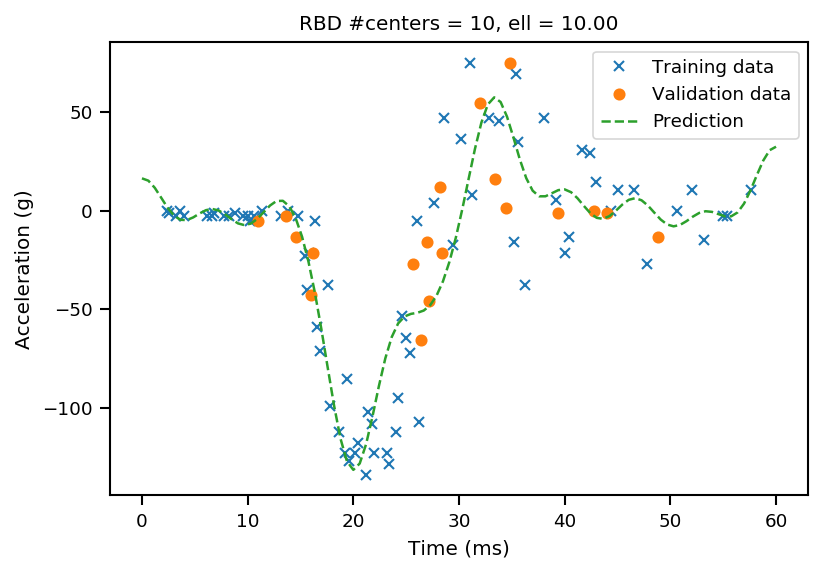

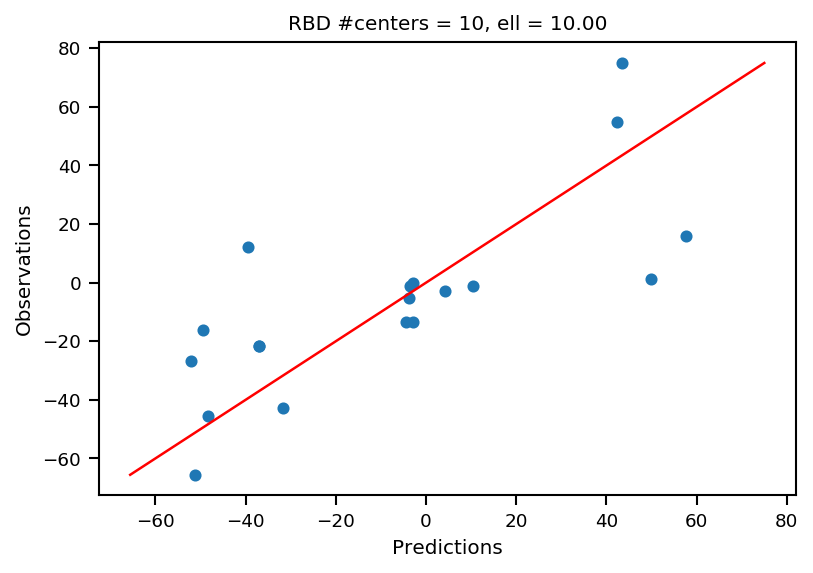

In [95]:
# Fit the RBF model
rbf_centers = np.linspace(0.0, 60.0, 10)
rbf_ell = 10
Phi_rbf_train = get_rbf_design_matrix(x_train[:, None], rbf_centers, rbf_ell)
w_rbf, _, _, _ = np.linalg.lstsq(Phi_rbf_train, y_train, rcond=None)
# Plot the function when possible
xx = np.linspace(0, 60, 100)
Phi_rbf_xx = get_rbf_design_matrix(xx[:, None], rbf_centers, rbf_ell)
yy_predict = np.dot(Phi_rbf_xx, w_rbf)
fig, ax = plt.subplots(dpi=150)
ax.set_title('RBD #centers = {0:d}, ell = {1:1.2f}'.format(rbf_centers.shape[0], rbf_ell))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
# Make predictions on the validation data
Phi_rbf_valid = get_rbf_design_matrix(x_valid[:, None], rbf_centers, rbf_ell)
y_valid_predict = np.dot(Phi_rbf_valid, w_rbf)
# Calculate the mean square error
MSE_rbf = np.linalg.norm(y_valid_predict - y_valid)
print('MSE_rbf = {0:1.2f}'.format(MSE_rbf))
## Do the predictsions vs observations plots
fig, ax = plt.subplots(dpi=150)
ax.set_title('RBD #centers = {0:d}, ell = {1:1.2f}'.format(rbf_centers.shape[0], rbf_ell))
ax.plot(y_valid_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

In [99]:
# Start increasing the number of Fourier terms and check the mean square error
# Fit the Fourier model
MSE = []
for fourier_terms in range(1, 32):
    fourier_L = 60.0
    Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
    w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)
    # Make predictions on the validation data
    Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
    y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
    # Calculate the mean square error
    MSE_fourier = np.linalg.norm(y_valid_predict - y_valid)
    MSE.append(MSE_fourier)

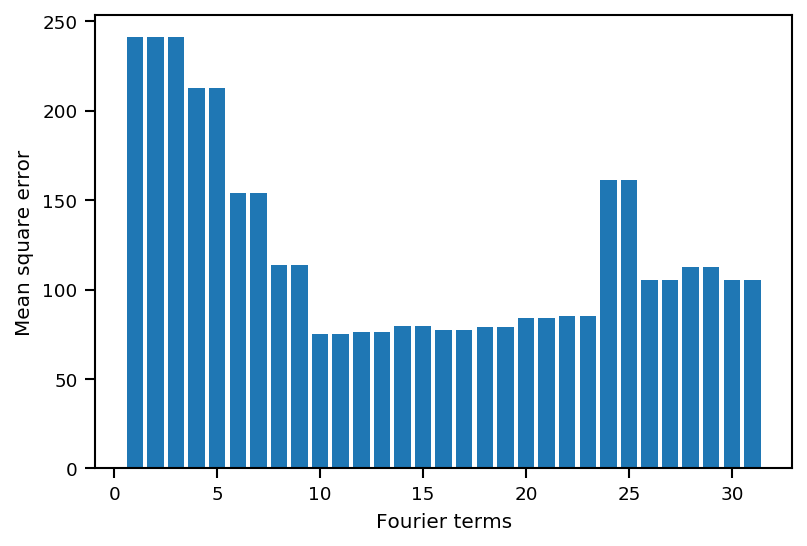

In [100]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(1, 32), MSE)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error');

In [98]:
# Cross validation
# Start increasing the number of Fourier terms and check the mean square error
# Fit the Fourier model
MSE = []
num_folds = 100
fourier_L = 60.0
train_percentage = 0.8
# Figure out how many training points you are going to use:
num_train = int(num_obs * train_percentage)
# Figure out how many validation points you are going to use:
num_valid = num_obs - num_train
for fourier_terms in range(1, 10):
    mse_sum = 0.0
    for fold in range(num_folds):
        permuted_data = np.random.permutation(data)
        train_data = permuted_data[:num_train]
        valid_data = permuted_data[num_train:]
        x_train = train_data[:, 0]
        y_train = train_data[:, 1]
        x_valid = valid_data[:, 0]
        y_valid = valid_data[:, 1]
        Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
        w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)
        # Make predictions on the validation data
        Phi_fourier_valid = get_fourier_design_matrix(x_valid[:, None], fourier_L, fourier_terms)
        y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
        # Calculate the mean square error
        MSE_fourier = np.linalg.norm(y_valid_predict - y_valid)
        mse_sum += MSE_fourier
    MSE.append(mse_sum / num_folds)

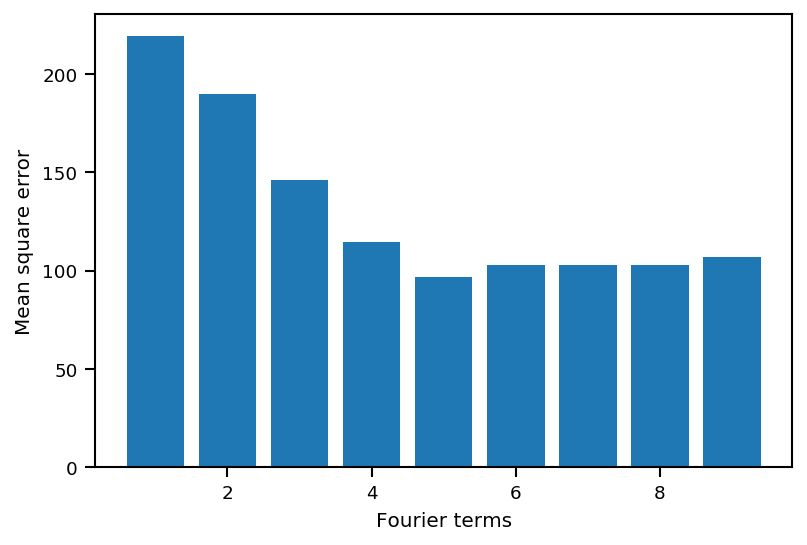

In [87]:
fig, ax = plt.subplots(dpi=150)
ax.bar(range(1, 10), MSE)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error');